In [240]:
# Data found at
# https://github.com/GeorgeMcIntire/fake_real_news_dataset

library(tidyverse)
library(tidytext)
library(stringr)
data(stop_words)
options(repr.plot.height = 3)
options(warn=-1)

In [242]:
data = read_csv('./data/fake_or_real_news.csv')

Parsed with column specification:
cols(
  X1 = col_integer(),
  title = col_character(),
  text = col_character(),
  label = col_character()
)


In [212]:
# Number of UNIQUELY titled articles

n = nrow(data)

unique_n = data %>%
    group_by(title) %>%
    summarise(n = n()) %>%
    nrow()

n
unique_n
n - unique_n # Repetitions

[1] 6335

[1] 6256

[1] 79

In [213]:
# Real vs. Fake articles 
data %>% 
    group_by(label) %>% 
    summarise(n = n()) %>%
    mutate(freq = paste0(as.character(100*round(n / sum(n),2)),"%"))

label,n,freq
FAKE,3164,50%
REAL,3171,50%


In [281]:
df = data
df$total_words = sapply(df$text, function(x) length(unlist(strsplit(as.character(x), "\\W+"))))

X1,title,text,label,total_words


In [286]:
# An article has to have more than 500 words to count
df = df %>%
    filter(total_words > 500) %>%
    select(-total_words)

In [287]:
# Split by "\n" 
tidy_data = df %>% 
    mutate(text = strsplit(as.character(text), "\n")) %>% 
    unnest(text)
head(tidy_data)

X1,title,label,text
8476,You Can Smell Hillary’s Fear,FAKE,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam."
8476,You Can Smell Hillary’s Fear,FAKE,"In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI."
8476,You Can Smell Hillary’s Fear,FAKE,The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI.
8476,You Can Smell Hillary’s Fear,FAKE,But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election.
8476,You Can Smell Hillary’s Fear,FAKE,The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI.
8476,You Can Smell Hillary’s Fear,FAKE,The FBI’s leadership is being warned that the entire left-wing establishment will form a lynch mob if they continue going after Hillary. And the FBI’s credibility is being attacked by the media and the Democrats to preemptively head off the results of the investigation of the Clinton Foundation and Hillary Clinton.


In [288]:
# New line breaks per label (proxy for a sentence or paragraph) - call it a snippet
tidy_data %>% 
    group_by(label) %>% 
    summarise(n = n()) %>%
    mutate(freq = paste0(as.character(100*round(n / sum(n),2)),"%"))

label,n,freq
FAKE,31735,22%
REAL,111661,78%


In [289]:
# Split into words
tidy_news = tidy_data %>% 
    group_by(title) %>% 
    mutate(linenumber = row_number()) %>% 
    ungroup() %>% 
    unnest_tokens(word,text) %>% 
    anti_join(stop_words) %>%
    drop_na()

Joining, by = "word"


In [290]:
# Words per label
tidy_news %>% 
    group_by(label) %>% 
    summarise(n = n()) %>%
    mutate(freq = paste0(as.character(100*round(n / sum(n),2)),"%"))

label,n,freq
FAKE,793548,40%
REAL,1168995,60%


In [269]:
news_sentiment <- tidy_news %>%
  inner_join(get_sentiments("bing")) %>%
  count(label, index = linenumber %/% 2, sentiment) %>%
  spread(sentiment, n, fill = 0) %>%
  mutate(sentiment = positive - negative) 
head(news_sentiment,10)

Joining, by = "word"


label,index,negative,positive,sentiment
FAKE,0,11102,7543,-3559
FAKE,1,8784,5883,-2901
FAKE,2,6381,4582,-1799
FAKE,3,6008,4033,-1975
FAKE,4,5053,3422,-1631
FAKE,5,4378,2829,-1549
FAKE,6,3657,2379,-1278
FAKE,7,3018,1963,-1055
FAKE,8,2568,1660,-908
FAKE,9,2157,1337,-820


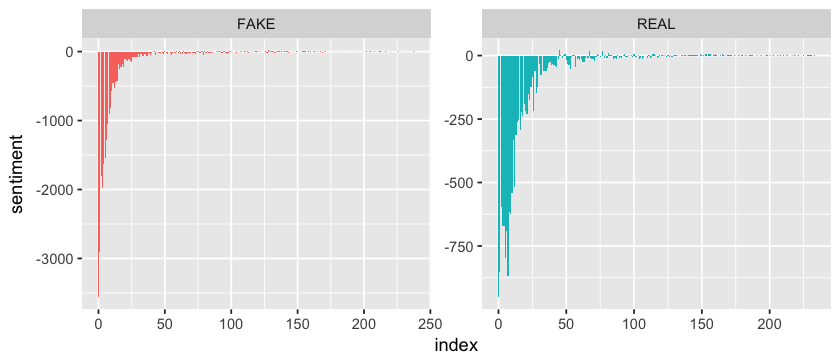

In [293]:
ggplot(news_sentiment, aes(index, sentiment, fill = label)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~label, ncol = 2, scales = "free")

In [294]:
fake = tidy_news %>% filter(label == 'FAKE')

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


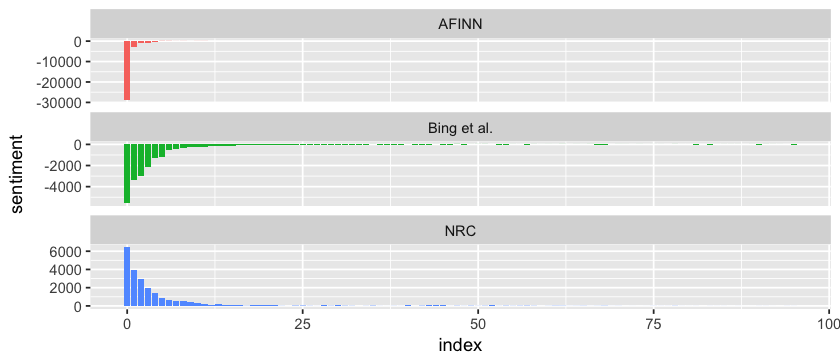

In [295]:
afinn <- fake %>% 
  inner_join(get_sentiments("afinn")) %>% 
  group_by(index = linenumber %/% 40) %>% 
  summarise(sentiment = sum(score)) %>% 
  mutate(method = "AFINN")

bing_and_nrc <- bind_rows(fake %>% 
                            inner_join(get_sentiments("bing")) %>%
                            mutate(method = "Bing et al."),
                          fake %>% 
                            inner_join(get_sentiments("nrc") %>% 
                                         filter(sentiment %in% c("positive", 
                                                                 "negative"))) %>%
                            mutate(method = "NRC")) %>%
  count(method, index = linenumber %/% 5, sentiment) %>%
  spread(sentiment, n, fill = 0) %>%
  mutate(sentiment = positive - negative)

bind_rows(afinn, 
          bing_and_nrc) %>%
  ggplot(aes(index, sentiment, fill = method)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~method, ncol = 1, scales = "free_y")


Joining, by = "word"
Selecting by n


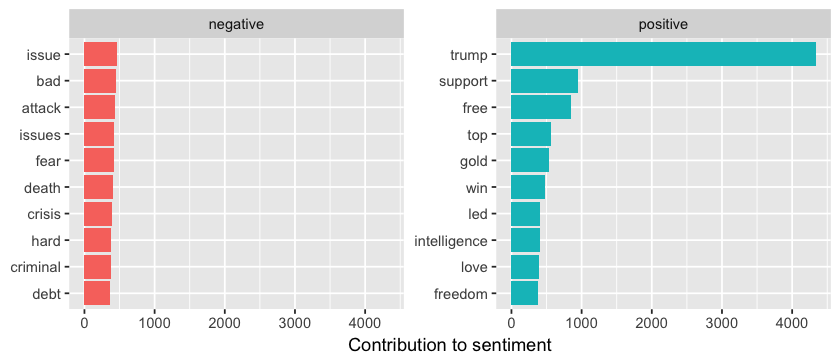

In [296]:
bing_word_counts <- tidy_news %>% filter(label == 'FAKE') %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()

bing_word_counts %>%
  group_by(sentiment) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(y = "Contribution to sentiment",
       x = NULL) +
  coord_flip()

Joining, by = "word"
Selecting by n


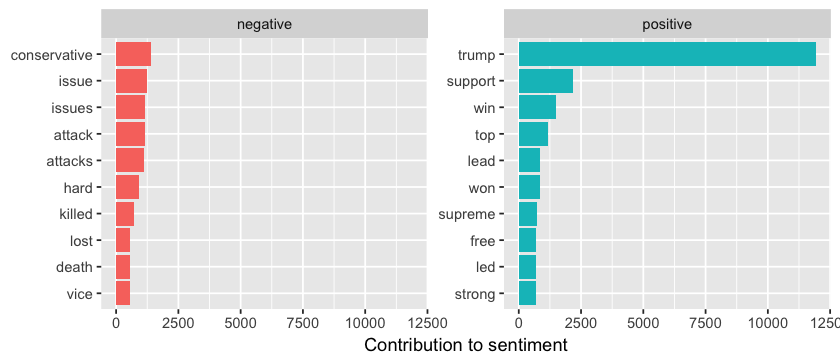

In [297]:
bing_word_counts <- tidy_news %>% filter(label == 'REAL') %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()

bing_word_counts %>%
  group_by(sentiment) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(y = "Contribution to sentiment",
       x = NULL) +
  coord_flip()

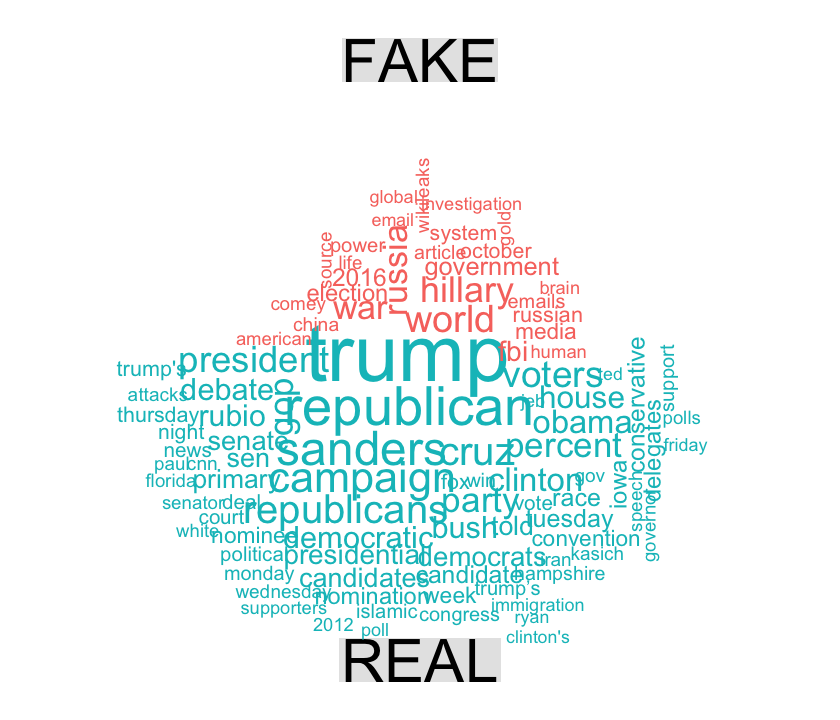

In [299]:
library(reshape2)
library(tm)
library(tmap)
library(wordcloud)
options(repr.plot.height = 6)

tidy_news %>% filter(label == 'FAKE' | label == 'REAL') %>%
  count(word, label, sort = TRUE) %>%
  acast(word ~ label, value.var = "n", fill = 0) %>%
  comparison.cloud(colors = c("#F8766D", "#00BFC4"),
                   max.words = 100)

In [138]:
options(repr.plot.height = 3)

bingnegative <- get_sentiments("bing") %>% 
  filter(sentiment == "negative")

wordcounts <- tidy_news %>%
  group_by(label,title) %>%
  summarize(words = n())

negative_sentiment_ratio = tidy_news %>%
  semi_join(bingnegative) %>%
  group_by(label,title) %>%
  summarize(negativewords = n()) %>%
  left_join(wordcounts, by = c("label", "title")) %>%
  mutate(ratio = negativewords/words) %>%
  filter(label == 'REAL' | label == 'FAKE') %>%
  top_n(3) %>%
  ungroup()

negative_sentiment_ratio



Joining, by = "word"
Selecting by ratio


label,title,negativewords,words,ratio
FAKE,"“CLINTON, INC”: WATCH HOW’S IT PAINS MSM TO REPORT CLINTON CORRUPTION",4,28,0.14285714
FAKE,"3 Effects of Substance Abuse on Individual, Family and Community",6,32,0.18750000
FAKE,Hillary IMPLODES: Trump 'Took Everything...Paid Nothing To Support Us!',1,6,0.16666667
REAL,Media turn blind eye to Hillary Clinton’s glaring mistakes,67,774,0.08656331
REAL,President Obama's persistent and puzzling passivity on terrorism,13,160,0.08125000
REAL,World's newspapers react to 'Hebdo' attack,10,108,0.09259259


In [139]:
bingpositive <- get_sentiments("bing") %>% 
  filter(sentiment == "positive")

wordcounts <- tidy_news %>%
  group_by(label,title) %>%
  summarize(words = n())

positive_sentiment_ratio = tidy_news %>%
  semi_join(bingpositive) %>%
  group_by(label,title) %>%
  summarize(positivewords = n()) %>%
  left_join(wordcounts, by = c("label", "title")) %>%
  mutate(ratio = positivewords/words) %>%
  filter(label == 'REAL' | label == 'FAKE') %>%
  top_n(3) %>%
  ungroup()

positive_sentiment_ratio

Joining, by = "word"
Selecting by ratio


label,title,positivewords,words,ratio
FAKE,8 classic football banners of our time,5,48,0.10416667
FAKE,"Make music great again, with these 10 Trumped up album covers",5,51,0.09803922
FAKE,What You’re Not Told: 90% Of American Media Is Controlled By Six Corporations,3,32,0.09375000
REAL,Senate GOP leaving tea party primary battles behind,2,14,0.14285714
REAL,Senate race rankings: Dems attack as GOP lays swing-state groundwork,2,14,0.14285714
REAL,The GOP's big-money plan to save the Senate,2,14,0.14285714


In [170]:
news_wordcounts <- tidy_news %>%
    group_by(label,word) %>%
    summarize(cnt = n()) %>%
    top_n(20)
    arrange(-cnt) %>%
head(news_wordcounts)

Selecting by cnt


ERROR: Error in arrange(-cnt): object 'cnt' not found


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x

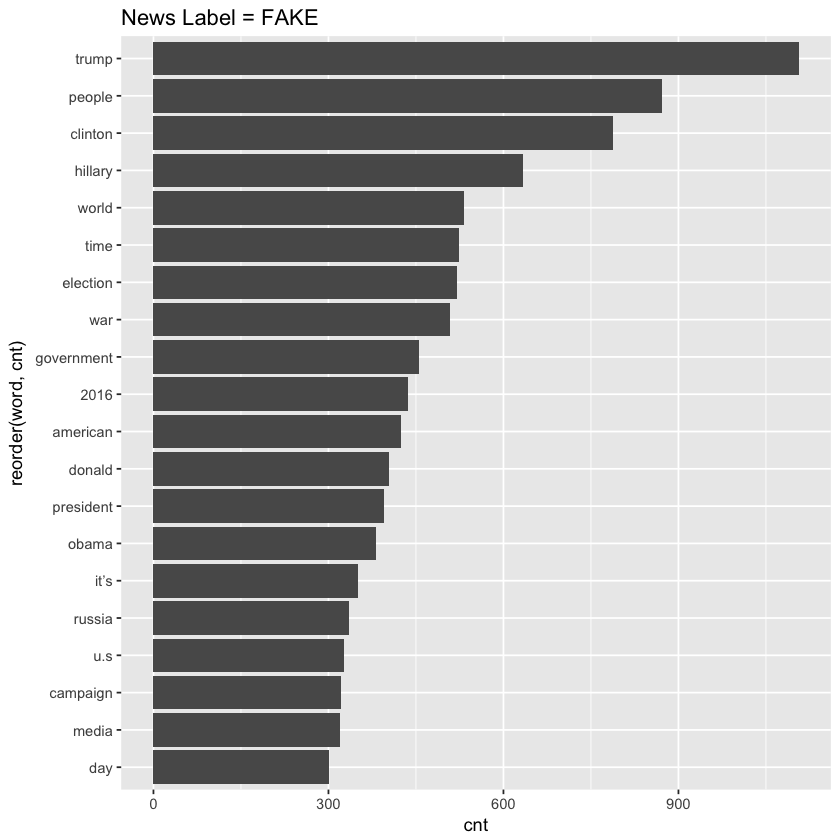

In [179]:
news_type = 'FAKE'
ggplot(news_wordcounts %>% filter(label == news_type), aes(x=reorder(word,cnt),y=cnt)) + 
    geom_bar(stat='identity') + 
    coord_flip() + ggtitle(paste0('News Label = ', news_type))

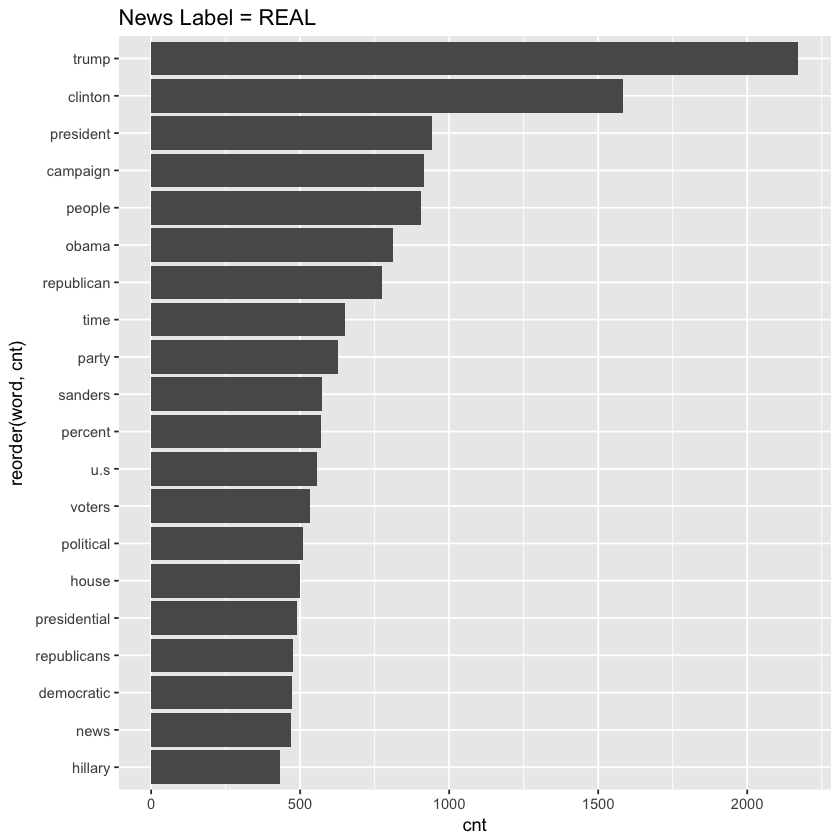

In [176]:
news_type = 'REAL'
ggplot(news_wordcounts %>% filter(label == news_type), aes(x=reorder(word,cnt),y=cnt)) + 
    geom_bar(stat='identity') + 
    coord_flip() + ggtitle(paste0('News Label = ', news_type))

In [189]:
news_tf_idf <- tidy_news %>%
  count(label, word) %>%
  bind_tf_idf(word, label, n) %>%
  arrange(-tf_idf) %>%
    top_n(50, tf_idf)
head(news_tf_idf)


label,word,n,tf,idf,tf_idf
FAKE,lesley,146,0.0008841787,0.6931472,0.0006128659
FAKE,stahl,144,0.0008720666,0.6931472,0.0006044705
REAL,mcconnell,67,0.0003311193,0.6931472,0.0002295144
REAL,p.m,63,0.0003113510,0.6931472,0.0002158120
REAL,caucuses,61,0.0003014668,0.6931472,0.0002089609
FAKE,https,49,0.0002967449,0.6931472,0.0002056879


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'rubio’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnno

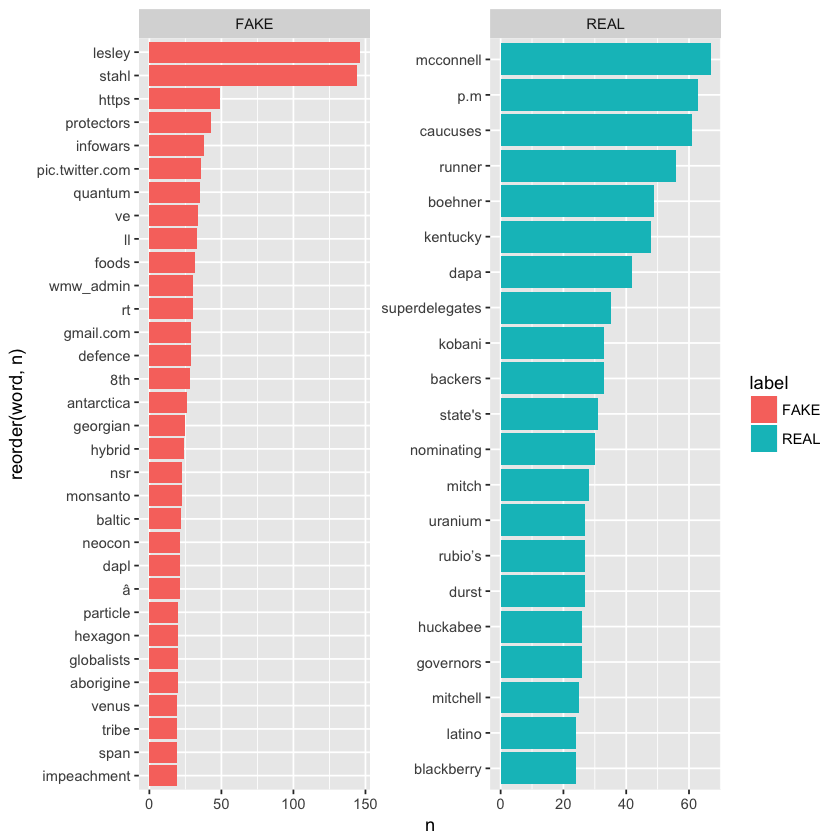

In [185]:
ggplot(news_tf_idf, aes(x=reorder(word,n), y=n, fill=label)) + 
    geom_bar(stat='identity') + 
    facet_wrap(~label,scales='free') + 
    coord_flip()

In [191]:
news_tf_idf <- tidy_news %>%
  count(label, word) %>%
  bind_tf_idf(word, label, n) %>%
  arrange(-tf_idf) %>%
    top_n(50, n)
head(news_tf_idf)

label,word,n,tf,idf,tf_idf
FAKE,2016,436,0.002640424,0,0
FAKE,american,424,0.002567752,0,0
FAKE,clinton,787,0.004766086,0,0
FAKE,donald,403,0.002440575,0,0
FAKE,election,520,0.003149129,0,0
FAKE,government,455,0.002755488,0,0


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x

“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <80>”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'it’s' in 'mbcsToSbcs': dot substituted for <99>”Warn

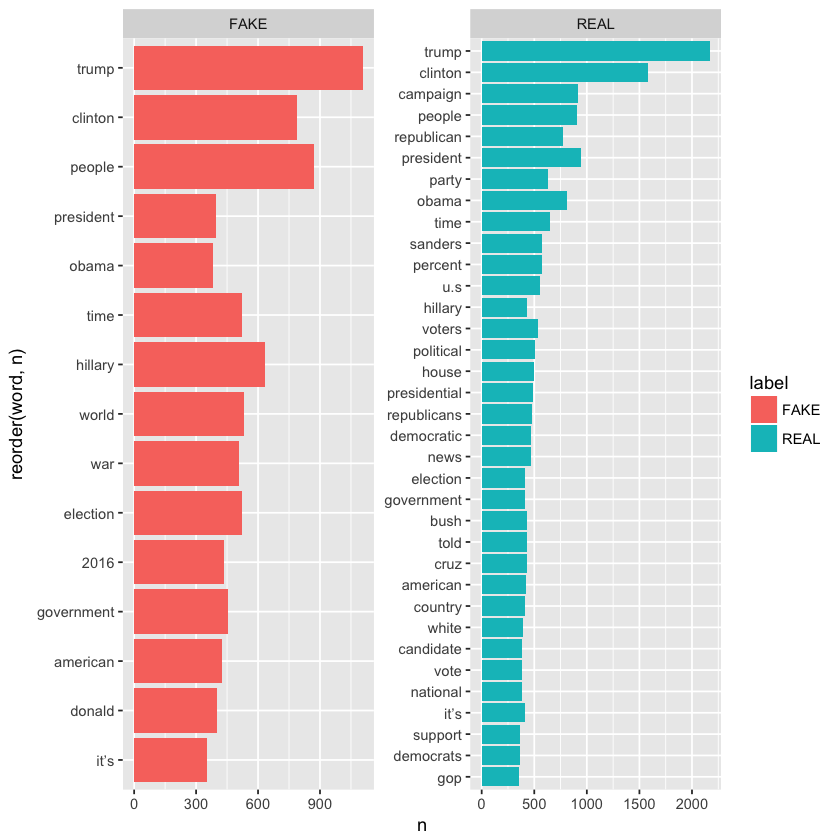

In [192]:
ggplot(news_tf_idf, aes(x=reorder(word,n), y=n, fill=label)) + 
    geom_bar(stat='identity') + 
    facet_wrap(~label,scales='free') + 
    coord_flip()

In [23]:
library(janeaustenr)

In [ ]:
ggplot(news_tf_idf, aes(x=reorder(word,n), y=n, fill=label)) + 
    geom_bar(stat='identity') + 
    facet_wrap(~label,scales='free') + 
    coord_flip()

In [24]:
tidy_books <- austen_books() %>% group_by(book) %>% mutate(linenumber = row_number())
head(tidy_books)

text,book,linenumber
SENSE AND SENSIBILITY,Sense & Sensibility,1
,Sense & Sensibility,2
by Jane Austen,Sense & Sensibility,3
,Sense & Sensibility,4
(1811),Sense & Sensibility,5
,Sense & Sensibility,6


In [26]:
a = austen_books()
a[300:400,]

text,book
"hundred, or even fifty pounds from our own expenses.""",Sense & Sensibility
,Sense & Sensibility
"""I believe you are right, my love; it will be better that there should",Sense & Sensibility
be no annuity in the case; whatever I may give them occasionally will,Sense & Sensibility
"be of far greater assistance than a yearly allowance, because they",Sense & Sensibility
would only enlarge their style of living if they felt sure of a larger,Sense & Sensibility
"income, and would not be sixpence the richer for it at the end of the",Sense & Sensibility
year. It will certainly be much the best way. A present of fifty,Sense & Sensibility
"pounds, now and then, will prevent their ever being distressed for",Sense & Sensibility
"money, and will, I think, be amply discharging my promise to my father.""",Sense & Sensibility
